# Homework 3: Prediction and Classification

# Introduction
在这个任务中，您将使用回归和分类来探索不同的数据集。

**第一**：您将使用2002年之前在[Sean Lahman's Baseball Database](http://seanlahman.com/baseball-archive/statistics) 的棒球数据库中创建一个使用线性回归来挑选棒球选手的指标。这是我们在家庭作业1中使用的相同的数据库。该数据库包含“从1871年到2013年的完全击球和投球统计数据，以及场地统计，排名，队伍统计，管理记录，赛后数据等”。[Documentation provided here](http://seanlahman.com/files/database/readme2012.txt).

**第二**：您将使用着名的[iris](http://en.wikipedia.org/wiki/Iris_flower_data_set)，使用交叉验证来执行kk-neareast邻居分类。虽然它是在1936年推出的，但它仍然是机器学习社区中最受欢迎的示例数据集之一。维基百科描述的数据集如下：“数据集由三种虹膜（Iris setosa，Iris virginica和Iris versicolor）中的每一种组成的50个样本，从每个样本测量四个特征：萼片和花瓣的长度和宽度。以下是四个功能测量的图示：

!["iris data features"](http://sebastianraschka.com/Images/2014_python_lda/iris_petal_sepal.png)
http://sebastianraschka.com/Images/2014_python_lda/iris_petal_sepal.png

**第三**：您将使用称为数字[digits data set](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)数据集的机器学习中的另一个标准数据集来调查更高维空间对分类的影响。该数据集与讲座中讨论的MNIST数据集类似。主要区别在于，每个数字由8×8像素的图像表示，远远小于MNIST的28x28像素。此外，灰度值限制为16个不同的值（4位），而不是MNIST的256（8位）。

**最后**：为准备家庭作业4，我们希望您阅读以下有关预测2014年参议院中期选举的文章。

* [Nate Silver's Methodology at while at NYT](http://fivethirtyeight.blogs.nytimes.com/methodology/)
* [How The FiveThirtyEight Senate Forecast Model Works](http://fivethirtyeight.com/features/how-the-fivethirtyeight-senate-forecast-model-works/)
* [Pollster Ratings v4.0: Methodology](http://fivethirtyeight.com/features/pollster-ratings-v40-methodology/)
* [Pollster Ratings v4.0: Results](http://fivethirtyeight.com/features/pollster-ratings-v40-results/)
* [Nate Silver versus Sam Wang](http://www.washingtonpost.com/blogs/plum-line/wp/2014/09/17/nate-silver-versus-sam-wang/)
* [More Nate Silver versus Sam Wang](http://www.dailykos.com/story/2014/09/09/1328288/-Get-Ready-To-Rumbllllle-Battle-Of-The-Nerds-Nate-Silver-VS-Sam-Wang)
* [Nate Silver explains critisims of Sam Wang](http://politicalwire.com/archives/2014/10/02/nate_silver_rebuts_sam_wang.html)
* [Background on the feud between Nate Silver and Sam Wang](http://talkingpointsmemo.com/dc/nate-silver-sam-wang-feud)
* [Are there swing voters?]( http://www.stat.columbia.edu/~gelman/research/unpublished/swing_voters.pdf)

## Load Python modules

In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import requests 
from io import StringIO, BytesIO
import zipfile
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 

# If this module is not already installed, you may need to install it. 
# You can do this by typing 'pip install seaborn' in the command line
import seaborn as sns 

import sklearn
import sklearn.datasets
import sklearn.cross_validation
import sklearn.decomposition
import sklearn.grid_search
import sklearn.neighbors
import sklearn.metrics

## 问题1：赛博计量学Sabermetrics
使用2002年赛季之前的数据，选出10名球员，并保证工资低于2000万美元（分配给每位球员中位数）。预测这支球队在162场比赛中将会获得多少场比赛。 

在这个问题中，我们将回到我们在家庭作业1中使用的[肖恩·拉曼的棒球数据库](http://seanlahman.com/baseball-archive/statistics)。从这个数据库中，我们将提取包含例如每年的统计数据和统计数字，击球统计数据，实地统计数据，球员名称，球员薪水和履历的五个数据集。您将探索此数据库中2002年之前的数据，并创建挑选球员的指标。

#### 问题1（a）：
Load in [these CSV files](http://seanlahman.com/files/database/lahman-csv_2014-02-14.zip) from the [Sean Lahman's Baseball Database](http://seanlahman.com/baseball-archive/statistics). For this assignment, we will use the 'Teams.csv', 'Batting.csv', 'Salaries.csv', 'Fielding.csv', 'Master.csv' tables. Read these tables into separate pandas DataFrames with the following names. 

CSV file name | Name of pandas DataFrame
:---: | :---: 
Teams.csv | teams
Batting.csv | players
Salaries.csv | salaries
Fielding.csv | fielding
Master.csv | master

In [2]:
# your code here
def getZIP(zipFileName):
    r = requests.get(zipFileName).content
    s = BytesIO(r)
    zf = zipfile.ZipFile(s, 'r') # Read in a list of zipped files
    return zf

url = 'http://seanlahman.com/files/database/lahman-csv_2014-02-14.zip'
zf = getZIP(url)
tablenames = zf.namelist()
print(tablenames)

['SchoolsPlayers.csv', 'SeriesPost.csv', 'Teams.csv', 'TeamsFranchises.csv', 'TeamsHalf.csv', 'AllstarFull.csv', 'Appearances.csv', 'AwardsManagers.csv', 'AwardsPlayers.csv', 'AwardsShareManagers.csv', 'AwardsSharePlayers.csv', 'Batting.csv', 'BattingPost.csv', 'Fielding.csv', 'FieldingOF.csv', 'FieldingPost.csv', 'HallOfFame.csv', 'Managers.csv', 'ManagersHalf.csv', 'Master.csv', 'Pitching.csv', 'PitchingPost.csv', 'readme2013.txt', 'Salaries.csv', 'Schools.csv']


In [3]:
teams = pd.read_csv(zf.open(tablenames[tablenames.index('Teams.csv')]))
players = pd.read_csv(zf.open(tablenames[tablenames.index('Batting.csv')]))
salaries = pd.read_csv(zf.open(tablenames[tablenames.index('Salaries.csv')]))
fielding = pd.read_csv(zf.open(tablenames[tablenames.index('Fielding.csv')]))
master = pd.read_csv(zf.open(tablenames[tablenames.index('Master.csv')]))

In [4]:
print("Dimensions of teams DataFrame:", teams.shape)
print("Dimensions of players DataFrame:", players.shape)
print("Dimensions of salaries DataFrame:", salaries.shape)
print("Dimensions of fielding DataFrame:", fielding.shape)
print("Dimensions of master DataFrame:", master.shape)

Dimensions of teams DataFrame: (2745, 48)
Dimensions of players DataFrame: (97889, 24)
Dimensions of salaries DataFrame: (23956, 5)
Dimensions of fielding DataFrame: (166991, 18)
Dimensions of master DataFrame: (18354, 24)


#### 问题1（b）：
计算每个球员的收入的中位数，并创建一个名为`medianSalaries`的DataFrame，其中有四列：（1）球员ID，（2）球员的名字，（3）球员的姓氏，（4）球员工资的中位数。显示`medianSalaries`DataFrame的头部。

In [6]:
# your code here
byPlayerID = salaries.groupby('playerID')['playerID', 'salary'].median()
medianSalaries = pd.merge(master[['playerID', 'nameFirst', 'nameLast']], byPlayerID, 
                         left_on='playerID', right_index=True)
medianSalaries.head()

,playerID,nameFirst,nameLast,salary
0,aardsda01,David,Aardsma,419000
3,aasedo01,Don,Aase,612500
4,abadan01,Andy,Abad,327000
5,abadfe01,Fernando,Abad,451500
13,abbotje01,Jeff,Abbott,255000


#### 问题1（c）：
现在，只考虑团队/季节组合，打162场的球队。排除从1947年以前的所有数据。Compute the per plate appearance rates for singles, doubles, triples, HR, and BB。创建一个名为`stats`的新的DataFrame，其中包含teamID，yearID，wins和这些比率。 

**提示**：Singles are hits that are not doubles, triples, nor HR. Plate appearances are base on balls plus at bats.

In [7]:
# your code here
subTeams = teams[(teams['G'] == 162) & (teams['yearID'] > 1947)].copy()

subTeams['1B'] = subTeams.H - subTeams['2B'] - subTeams['3B'] - subTeams['HR']
subTeams['PA'] = subTeams.BB + subTeams.AB

for col in ['1B', '2B', '3B', 'HR', 'BB']:
    subTeams[col] = subTeams[col] / subTeams.PA

stats = subTeams[['teamID', 'yearID', 'W', '1B', '2B', '3B', 'HR', 'BB']].copy()
stats.head()

,teamID,yearID,W,1B,2B,3B,HR,BB
1366,LAA,1961,70,0.147748,0.035708,0.003604,0.030958,0.111548
1367,KC1,1961,61,0.164751,0.035982,0.007829,0.014993,0.096618
1377,NYA,1962,96,0.167148,0.038536,0.004656,0.031952,0.093770
1379,LAA,1962,86,0.159482,0.038027,0.005737,0.022455,0.098672
1381,CHA,1962,85,0.165797,0.040756,0.009129,0.014998,0.101076


#### 问题1（d）：
在问题1（c）中计算的rate是否有明显的时间趋势？

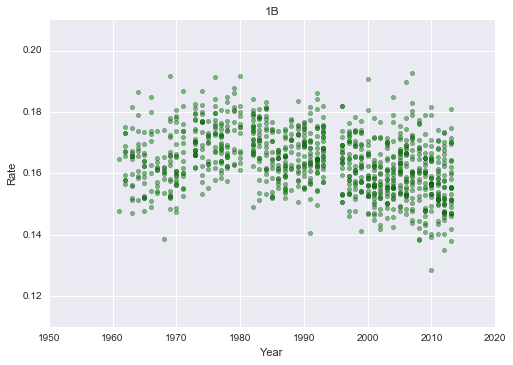

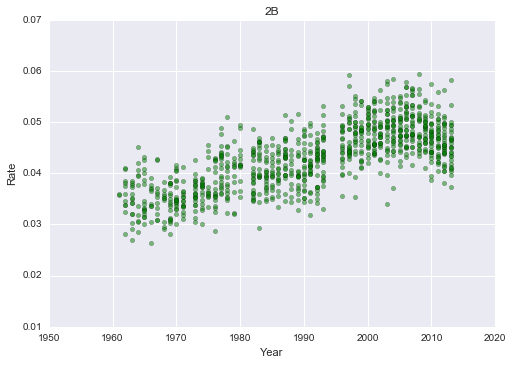

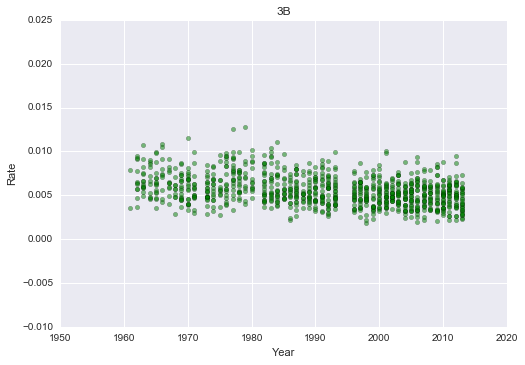

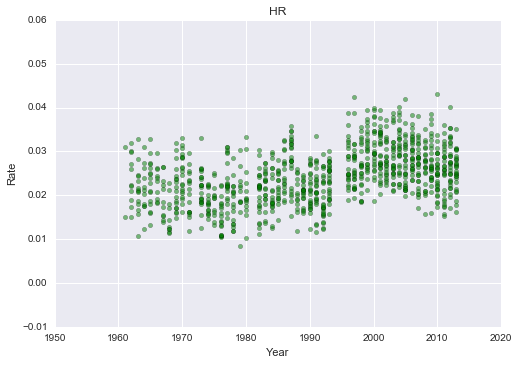

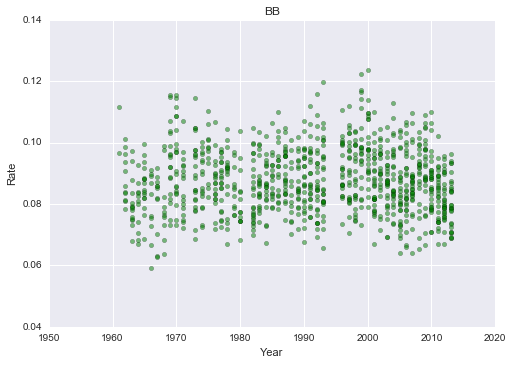

In [8]:
# your code here
for col in ['1B', '2B', '3B', 'HR', 'BB']:
    plt.scatter(stats.yearID, stats[col], c='g', alpha=0.5)
    plt.title(col)
    plt.xlabel('Year')
    plt.ylabel('Rate')
    plt.show()

#### 问题1（e）：
Using the stats DataFrame from Problem 1(c), adjust the singles per PA rates so that the average across teams for each year is 0. Do the same for the doubles, triples, HR, and BB rates

In [9]:
# your code here
stats.head()

,teamID,yearID,W,1B,2B,3B,HR,BB
1366,LAA,1961,70,0.147748,0.035708,0.003604,0.030958,0.111548
1367,KC1,1961,61,0.164751,0.035982,0.007829,0.014993,0.096618
1377,NYA,1962,96,0.167148,0.038536,0.004656,0.031952,0.093770
1379,LAA,1962,86,0.159482,0.038027,0.005737,0.022455,0.098672
1381,CHA,1962,85,0.165797,0.040756,0.009129,0.014998,0.101076


First check what the mean is across teams for each year for each of the rates.

In [10]:
stats.groupby('yearID').mean().head()

,W,1B,2B,3B,HR,BB
yearID,,,,,,
1961,65.500000,0.156249,0.035845,0.005717,0.022975,0.104083
1962,78.454545,0.165632,0.035853,0.006777,0.023811,0.088590
1963,78.142857,0.162467,0.034020,0.006896,0.021254,0.080336
1964,81.727273,0.167251,0.036336,0.006748,0.021548,0.079152
1965,82.000000,0.160042,0.035539,0.006534,0.022693,0.085745


Now we define a function to mean normalize the rates.

In [11]:
def meanNormalizeRates(df):
        subRates = df[["1B","2B","3B","HR","BB"]]
        df[["1B","2B","3B","HR","BB"]] = subRates - subRates.mean(axis=0)
        return df

stats = stats.groupby('yearID').apply(meanNormalizeRates)

In [12]:
stats.head()

,teamID,yearID,W,1B,2B,3B,HR,BB
1366,LAA,1961,70,-0.008502,-0.000137,-0.002113,0.007983,0.007465
1367,KC1,1961,61,0.008502,0.000137,0.002113,-0.007983,-0.007465
1377,NYA,1962,96,0.001516,0.002683,-0.002121,0.008141,0.005180
1379,LAA,1962,86,-0.006150,0.002174,-0.001040,-0.001356,0.010082
1381,CHA,1962,85,0.000165,0.004904,0.002352,-0.008813,0.012486


#### 问题1（f）：
建立一个简单的线性回归模型，从average adjusted singles，double, triples, HR, and BB rates来预测获胜的数量。为了确定这些项中哪些项适合2002年以前的数据，并计算从2002年以后的平均残差平方值，使用拟合模型来定义新的体系总结：offensive predicted wins攻击性预测胜利（OPW）。

**提示**：新摘要应该是五个项中一到五种的线性组合。

In [13]:
# your code here
from sklearn import linear_model
clf = linear_model.LinearRegression()

stat_train = stats[stats.yearID < 2002]
stat_test = stats[stats.yearID >= 2002]

XX_train = stat_train[["1B","2B","3B","HR","BB"]].values
XX_test = stat_test[["1B","2B","3B","HR","BB"]].values

YY_train = stat_train.W.values
YY_test = stat_test.W.values

clf.fit(XX_train, YY_train)
print(clf.coef_)

print('Mean Squared Error: {:.2f}'.format(np.mean((YY_test - clf.predict(XX_test)) **2)))

[  523.51121499   479.73673295  1138.48602313   851.67216873   511.45942978]
Mean Squared Error: 83.82


回答：从上面的模型，我们定义的模型是所有五个rates的线性组合，因为它是具有最小均方误差的结果。

#### 问题1（g）：
现在我们将为每个球员创建一个类似的数据库。只考虑球员/年度的球员至少有500个板块出现。只考虑我们考虑上述计算的年份（1947年以后的162场比赛）。对于每个球员/年度，计算singles, doubles, triples, HR, BB每plate的出现率。创建一个名为`playerstats`的新的DataFrame，其具有playerID，yearID和这些统计信息。删除问题1（e）中每年的这些统计信息的平均值。

In [14]:
players.head()

,playerID,yearID,stint,teamID,lgID,G,G_batting,AB,R,H,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,G_old
0,aardsda01,2004,1,SFN,NL,11,11.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
1,aardsda01,2006,1,CHN,NL,45,43.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,45.0
2,aardsda01,2007,1,CHA,AL,25,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,aardsda01,2008,1,BOS,AL,47,5.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0
4,aardsda01,2009,1,SEA,AL,73,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [19]:
# your code here
subPlayers = players[(players.AB + players.BB) > 500 & (players.yearID > 1947)].copy()

subPlayers["1B"] = subPlayers.H - subPlayers["2B"] - subPlayers["3B"] - subPlayers["HR"]
subPlayers["PA"] = subPlayers.BB + subPlayers.AB

for col in ["1B","2B","3B","HR","BB"]:
    subPlayers[col] = subPlayers[col]/subPlayers.PA
    
# Create playerstats DataFrame
playerstats = subPlayers[["playerID","yearID","1B","2B","3B","HR","BB"]].copy()

In [20]:
playerstats.head()

,playerID,yearID,1B,2B,3B,HR,BB
8,aaronha01,1955,0.178187,0.056836,0.013825,0.041475,0.075269
9,aaronha01,1956,0.195046,0.052632,0.021672,0.040248,0.057276
10,aaronha01,1957,0.180060,0.040179,0.008929,0.065476,0.084821
11,aaronha01,1958,0.193939,0.051515,0.006061,0.045455,0.089394
12,aaronha01,1959,0.192647,0.067647,0.010294,0.057353,0.075000


In [21]:
playerstats = playerstats.groupby('yearID').apply(meanNormalizeRates)

In [22]:
playerstats.head()

,playerID,yearID,1B,2B,3B,HR,BB
8,aaronha01,1955,0.001060,0.018570,0.005585,0.011337,-0.027249
9,aaronha01,1956,0.021561,0.013857,0.012480,0.009593,-0.044600
10,aaronha01,1957,0.004817,-0.002034,0.000466,0.037093,-0.013166
11,aaronha01,1958,0.018367,0.011015,-0.002219,0.015398,-0.007762
12,aaronha01,1959,0.016261,0.025762,0.002743,0.028368,-0.022898


#### 问题1（h）：
使用在问题1（g）中创建的`playerstats`DataFrame，创建一个名为`playerLS`的新DataFrame，其中包含球员的职业生涯周期统计信息。该DataFrame应该包含playerID，球员职业生涯开始的一年，职业生涯结束的一年，以及球员的每个量（singles, doubles, triples, HR, BB）的终身平均水平。为了简单起见，我们将简单地按年计算每个量的平均值（更正确的方法是使用总数）。

In [23]:
# your code here
def meanNormalizePlayerLS(df):
    df = df[['playerID', '1B','2B','3B','HR','BB']].mean()
#     subRates = df[['1B','2B','3B','HR','BB']]
#     df[['1B','2B','3B','HR','BB']] = subRates - subRates.mean(axis=0)
    return df

def getyear(x):
    return int(x[0:4])

In [24]:
playerLS = playerstats.groupby('playerID').apply(meanNormalizePlayerLS).reset_index()
playerLS.head()

,playerID,1B,2B,3B,HR,BB
0,aaronha01,-0.007157,0.006539,-0.000270,0.027850,0.009447
1,abramca01,0.013463,-0.023915,0.002384,0.003842,0.019455
2,abreubo01,-0.008202,0.006421,0.001002,-0.003252,0.050501
3,ackledu01,-0.009270,-0.016605,-0.001974,-0.015274,0.001597
4,adairje01,0.011933,0.003286,-0.002139,-0.012934,-0.037229


In [25]:
playerLS = master[['playerID', 'debut', 'finalGame']].merge(playerLS, how='inner', on='playerID')
playerLS.head()

,playerID,debut,finalGame,1B,2B,3B,HR,BB
0,aaronha01,1954-04-13,1976-10-03,-0.007157,0.006539,-0.000270,0.027850,0.009447
1,abramca01,1949-04-20,1956-05-09,0.013463,-0.023915,0.002384,0.003842,0.019455
2,abreubo01,1996-09-01,2012-10-02,-0.008202,0.006421,0.001002,-0.003252,0.050501
3,ackledu01,2011-06-17,2013-09-29,-0.009270,-0.016605,-0.001974,-0.015274,0.001597
4,adairje01,1958-09-02,1970-05-03,0.011933,0.003286,-0.002139,-0.012934,-0.037229


In [86]:
playerLS.drop(playerLS.index[playerLS.debut.isnull()], inplace=1)

In [26]:
playerLS['debut'] = playerLS.debut.apply(getyear)
playerLS['finalGame'] = playerLS.finalGame.apply(getyear)
cols = playerLS.columns.tolist()
cols[1:3] = ['minYear', 'maxYear']
playerLS.columns = cols

In [27]:
playerLS.head()

,playerID,minYear,maxYear,1B,2B,3B,HR,BB
0,aaronha01,1954,1976,-0.007157,0.006539,-0.000270,0.027850,0.009447
1,abramca01,1949,1956,0.013463,-0.023915,0.002384,0.003842,0.019455
2,abreubo01,1996,2012,-0.008202,0.006421,0.001002,-0.003252,0.050501
3,ackledu01,2011,2013,-0.009270,-0.016605,-0.001974,-0.015274,0.001597
4,adairje01,1958,1970,0.011933,0.003286,-0.002139,-0.012934,-0.037229


#### 问题1（i）：
根据`playerLS` DataFrame中的平均rates计算每位球员的OPW。 You can interpret this summary statistic as the predicted wins for a team with 9 batters exactly like the player in question. 。将此列添加到playerLS DataFrame。调用这个colum OPW。

In [28]:
# your code here
avgRates = playerLS[["1B","2B","3B","HR","BB"]].values
playerLS["OPW"] = clf.predict(avgRates)
playerLS.head()

,playerID,minYear,maxYear,1B,2B,3B,HR,BB,OPW
0,aaronha01,1954,1976,-0.007157,0.006539,-0.000270,0.027850,0.009447,108.696139
1,abramca01,1949,1956,0.013463,-0.023915,0.002384,0.003842,0.019455,92.575472
2,abreubo01,1996,2012,-0.008202,0.006421,0.001002,-0.003252,0.050501,104.050008
3,ackledu01,2011,2013,-0.009270,-0.016605,-0.001974,-0.015274,0.001597,53.806003
4,adairje01,1958,1970,0.011933,0.003286,-0.002139,-0.012934,-0.037229,56.395050


#### 问题1（j）：
给`playerLS`增加4列，依次是球员的位置 (C, 1B, 2B, 3B, SS, LF, CF, RF, or OF)，名，姓，薪水的中位数。

In [41]:
fielding.head()

,playerID,yearID,stint,teamID,lgID,POS,G,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
0,ansonca01,1871,1,RC1,NaN,1B,1,NaN,NaN,7.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,biermch01,1871,1,FW1,NaN,1B,1,NaN,NaN,9.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN
2,carleji01,1871,1,CL1,NaN,1B,29,NaN,NaN,295.0,4.0,34.0,10.0,NaN,NaN,NaN,NaN,NaN
3,connone01,1871,1,TRO,NaN,1B,4,NaN,NaN,35.0,1.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN
4,cravebi01,1871,1,TRO,NaN,1B,2,NaN,NaN,18.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN


In [29]:
# your code here
from collections import defaultdict

def find_pos(df):
    positions = df.POS
    d = defaultdict(int)
    for pos in positions:
        d[pos] += 1
    result = max(d.items(), key=lambda x: x[1])
    return result[0]

positions_df = fielding.groupby("playerID").apply(find_pos)
positions_df = positions_df.reset_index()
positions_df = positions_df.rename(columns={0:"POS"})

In [42]:
positions_df.head()

,playerID,POS
0,aardsda01,P
1,aaronha01,OF
2,aaronto01,1B
3,aasedo01,P
4,abadan01,1B


In [43]:
medianSalaries.head()

,playerID,nameFirst,nameLast,salary
0,aardsda01,David,Aardsma,419000
3,aasedo01,Don,Aase,612500
4,abadan01,Andy,Abad,327000
5,abadfe01,Fernando,Abad,451500
13,abbotje01,Jeff,Abbott,255000


In [46]:
playerLS_merged = positions_df.merge(playerLS, how='inner', on='playerID')
playerLS_merged = playerLS_merged.merge(medianSalaries, how='inner', on='playerID')

In [96]:
playerLS_merged.head()

,playerID,POS,minYear,maxYear,1B,2B,3B,HR,BB,OPW,nameFirst,nameLast,salary
0,aardsda01,P,2004,2013,-0.130036,-0.036876,-0.002993,-0.016767,-0.068675,-57.514986,David,Aardsma,419000
1,aasedo01,P,1977,1990,-0.145414,-0.033008,-0.003839,-0.013106,-0.069358,-61.904626,Don,Aase,612500
2,abadan01,1B,2001,2006,-0.097641,-0.036281,-0.003680,-0.016559,0.103124,46.993005,Andy,Abad,327000
3,abadfe01,P,2010,2013,-0.055657,-0.032510,-0.003259,-0.016083,-0.064766,-14.203501,Fernando,Abad,451500
4,abbotje01,LF,1997,2001,0.031142,0.007942,-0.001997,0.006088,-0.016784,95.502802,Jeff,Abbott,255000


#### 问题1（k）：
取出在`playerLS` DataFrame中2002年和2003年活跃的球员，并且至少有三年职业生涯。绘制和描述中位数薪水（单位百万）和预测的获胜数之间的关系。

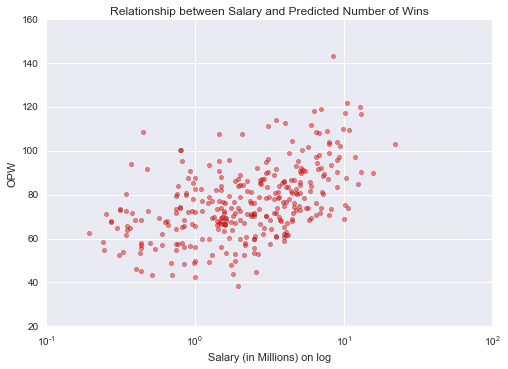

In [179]:
# your code here
active = playerLS_merged[(playerLS_merged['minYear'] <= 2002) & 
                         (playerLS_merged['maxYear'] >= 2003) &
                         (playerLS_merged['maxYear'] - playerLS_merged['minYear'] >= 3)]

fig = plt.figure()
ax = fig.gca()
ax.scatter(active.salary/ 1e6, active.OPW, alpha=0.5, c='red')
ax.set_xscale('log')
ax.set_xlabel('Salary (in Millions) on log')
ax.set_ylabel('OPW')
ax.set_title('Relationship between Salary and Predicted Number of Wins')
plt.show()

#### 问题1（I）：
从10个位置（C, 1B, 2B, 3B, SS, LF, CF, RF, DH, or OF ）中依次选出一个球员，并且保证10个球员的总薪水低于2千万。报告他们的平均预测的胜场和总薪水。

In [180]:
active.head()

,playerID,POS,minYear,maxYear,1B,2B,3B,HR,BB,OPW,nameFirst,nameLast,salary
0,abreubo01,RF,1996,2012,-0.008202,0.006421,0.001002,-0.003252,0.050501,104.050008,Bobby,Abreu,9000000
3,alfoned01,2B,1995,2006,0.013485,-0.002177,-0.003239,-0.006436,0.010745,83.404437,Edgardo,Alfonzo,4112500
5,allench01,LF,1999,2005,0.023014,-0.009664,0.000201,-0.016584,-0.031390,58.526131,Chad,Allen,240000
7,alomaro01,2B,1988,2004,0.022145,0.001698,0.002653,-0.009386,0.004503,90.800847,Roberto,Alomar,5466667
9,aloumo01,OF,1990,2008,0.004058,0.001022,-0.000406,0.009994,0.000737,92.104556,Moises,Alou,5135000


首先根据位置的中位数来标准化胜场数，存放在列`resid`中。

In [181]:
# your code here
def meanNormalizeOPW(df):
    tmp = df[['resid']]
    df[['resid']] = tmp - tmp.median(axis=0)
    return df

active['resid'] = active['OPW']
active = active.groupby('POS').apply(meanNormalizeOPW)
active.head()

D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,playerID,POS,minYear,maxYear,1B,2B,3B,HR,BB,OPW,nameFirst,nameLast,salary,resid
0,abreubo01,RF,1996,2012,-0.008202,0.006421,0.001002,-0.003252,0.050501,104.050008,Bobby,Abreu,9000000,16.510691
3,alfoned01,2B,1995,2006,0.013485,-0.002177,-0.003239,-0.006436,0.010745,83.404437,Edgardo,Alfonzo,4112500,11.217879
5,allench01,LF,1999,2005,0.023014,-0.009664,0.000201,-0.016584,-0.031390,58.526131,Chad,Allen,240000,-14.466879
7,alomaro01,2B,1988,2004,0.022145,0.001698,0.002653,-0.009386,0.004503,90.800847,Roberto,Alomar,5466667,18.614289
9,aloumo01,OF,1990,2008,0.004058,0.001022,-0.000406,0.009994,0.000737,92.104556,Moises,Alou,5135000,13.469787


拟合薪水和胜场的线性回归模型，并计算残差，保存在列`resid`中。

In [182]:
Y = active.resid.values
X = np.log(active[['salary']])

clf = linear_model.LinearRegression()
clf.fit(X, Y)

active['resid'] = Y - clf.predict(X)

In [183]:
active.head()

,playerID,POS,minYear,maxYear,1B,2B,3B,HR,BB,OPW,nameFirst,nameLast,salary,resid
0,abreubo01,RF,1996,2012,-0.008202,0.006421,0.001002,-0.003252,0.050501,104.050008,Bobby,Abreu,9000000,4.167002
3,alfoned01,2B,1995,2006,0.013485,-0.002177,-0.003239,-0.006436,0.010745,83.404437,Edgardo,Alfonzo,4112500,5.367017
5,allench01,LF,1999,2005,0.023014,-0.009664,0.000201,-0.016584,-0.031390,58.526131,Chad,Allen,240000,3.235931
7,alomaro01,2B,1988,2004,0.022145,0.001698,0.002653,-0.009386,0.004503,90.800847,Roberto,Alomar,5466667,10.403723
9,aloumo01,OF,1990,2008,0.004058,0.001022,-0.000406,0.009994,0.000737,92.104556,Moises,Alou,5135000,5.778098


取出在平均水平以上的球员。

In [184]:
active = active[active.resid >= 0]

通过位置计算最低薪水。我们将知道每个位置需要保留的最低金额是多少（并且知道我们可以花多少钱）。

In [185]:
def getMinSalary(s):
    return s['salary'].min()

minSalaryByPos = active.groupby('POS').apply(getMinSalary)
minSalaryByPos.sort_values(ascending=0)
minSalaryByPos

POS
1B     375000
2B     275000
3B     432500
C      350000
CF    1500000
DH    1000000
LF     195000
OF     315000
RF    1700000
SS     350000
dtype: int64

In [186]:
posleft = list(minSalaryByPos.index)
print(posleft)

['1B', '2B', '3B', 'C', 'CF', 'DH', 'LF', 'OF', 'RF', 'SS']


总金额需要在2千万以内：

In [187]:
moneyleft = 20*1e6

现在，我们将迭代所有的位置。我们持续记录我们需要组建一个团队的最低金额，并在每次迭代期间至少保持这个金额。在每次迭代中，我们选择我们负担得起的那些固定薪水条件下预期的OPW偏差最大的球员。

In [220]:
# indexes will contain the indexes of the players we chose
indexes=[]
moneyleft = 20*10**6
posleft = minSalaryByPos.index.tolist()

In [221]:
for i in range(len(posleft)):
    
    # you need to have at least this much left to not go over in the next picks
    maxmoney = moneyleft - sum([minSalaryByPos[x] for x in posleft[:-1] ])
    
    # consider only players in positions we have not selected
    if len(posleft) > 1:
        index = [True if elem in posleft[:-1] else False for elem in active.POS.values]
    else:
        index = [True if elem in posleft else False for elem in active.POS.values]
    left = active[index & (active.salary <= maxmoney)]
    
    # pick the one that stands out the most from what is expected given his salary
    j = left["resid"].argmax()
    indexes.append(j)
    
    # remove position we just filled from posleft
    posleft.remove(left.loc[j].POS)
    moneyleft = moneyleft - left.loc[j].salary
   
topPicks=active.loc[indexes,:]
topPicks=topPicks.sort_values(["OPW"],ascending=False)

总的花费：

In [222]:
topPicks['salary'].sum()

18070167

期望的胜场次数：

In [223]:
round(topPicks['OPW'].mean())

98

#### 问题1（M）：
What do these players outperform in? Singles, doubles, triples HR or BB?

In [224]:
# your code here
def round1000(x):
    return np.round(x*1000)

topPicks[["1B","2B","3B", "HR","BB"]] = topPicks[["1B","2B","3B", "HR","BB"]].apply(round1000)
topPicks[["OPW"]] = np.round(topPicks[["OPW"]])
topPicks[["nameFirst","nameLast","POS","1B","2B","3B", "HR","BB","OPW","salary","minYear","maxYear"]]

,nameFirst,nameLast,POS,1B,2B,3B,HR,BB,OPW,salary,minYear,maxYear
81,Barry,Bonds,OF,-45.0,1.0,1.0,31.0,112.0,143.0,8541667,1986,2007
274,Morgan,Ensberg,3B,-33.0,-3.0,-0.0,26.0,48.0,109.0,450000,2000,2008
475,Nick,Johnson,1B,-30.0,18.0,-3.0,-0.0,72.0,108.0,1450000,2001,2012
236,David,Dellucci,LF,-51.0,-19.0,5.0,24.0,57.0,100.0,812500,1997,2009
922,Jayson,Werth,RF,-15.0,-1.0,-4.0,12.0,33.0,96.0,1700000,2002,2013
848,Mike,Sweeney,DH,18.0,13.0,-4.0,7.0,-5.0,95.0,1450000,1995,2010
828,Junior,Spivey,2B,16.0,6.0,5.0,-8.0,8.0,95.0,816000,2001,2005
872,Andres,Torres,CF,-39.0,25.0,9.0,-3.0,6.0,84.0,1500000,2002,2013
966,Gregg,Zaun,C,-8.0,-17.0,-3.0,-11.0,52.0,83.0,1000000,1995,2010
454,Damian,Jackson,SS,-12.0,-1.0,6.0,-25.0,11.0,66.0,350000,1996,2006


Your answer here: Our best players all outperformed in BB.

## Discussion for Problem 1

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*
在这个问题中，我们用线性回归模型构造了一个挑选总薪水在2千万以下10个富有进攻性的球员的模型，并且用它预测这个团队能够在一个赛季（问题1（I））中赢下多少场。

---

## 问题2：k-Nearest Neighbors and Cross Validation

使用k最近邻分类对虹膜数据集提供的四个特征预测物种的最优k是什么。 

在这个问题中，您将了解着名的虹膜数据集，并使用交叉验证来选择k最近邻分类的最优k。这个问题集大大地使用了sklearn库。除了pandas，它是数据科学家最有用的库之一！完成作业任务后，您将了解所有的基础知识，以开始在sklearn完成自己的机器学习项目。

未来的讲座将会提供有关不同分类器及其具体优点和缺点的进一步背景信息，但是当您具有sklearn的基础知识时，更改分类器将是一到两行代码。 

这个数据集是如此受欢迎，所以sklearn提供了一个额外的功能来加载它：

In [302]:
#load the iris data set
iris = sklearn.datasets.load_iris()

X = iris.data  
Y = iris.target

print(X.shape, Y.shape)

(150, 4) (150,)


#### 问题2（a）：
Split the data into a train and a test set. Use a random selection of 33% of the samples as test data. Sklearn provides the train_test_split function for this purpose. Print the dimensions of all the train and test data sets you have created.

In [303]:
# your code here
X_train, X_test, Y_train, Y_test = sklearn.cross_validation.train_test_split(
    X, Y, test_size=0.33, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(100, 4)
(50, 4)
(100,)
(50,)


#### 问题2（b）：
Examine the data further by looking at the projections to the first two principal components of the data. Use the `TruncatedSVD` function for this purpose, and create a scatter plot. Use the colors on the scatter plot to represent the different classes in the target data.

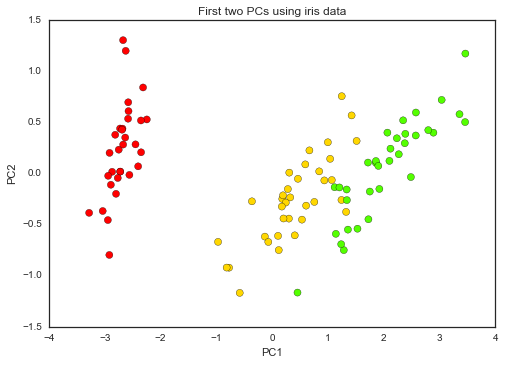

In [304]:
# your code here

# make a scatter plot of the data in two dimensions
svd = sklearn.decomposition.TruncatedSVD(n_components=2)
X_train_centered = X_train - np.mean(X_train, axis=0)
X_2d = svd.fit_transform(X_train_centered)

sns.set_style('white')

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=Y_train, s=50, cmap=plt.cm.prism)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First two PCs using iris data')
plt.show()

#### 问题2（c）：
In the lecture we discussed how to use cross validation to estimate the optimal value for kk (the number of nearest neighbors to base the classification on). Use ten fold cross validation to estimate the optimal value for kk for the iris data set.

**Note**: For your convenience sklearn does not only include the KNN classifier, but also a grid search function. The function is called grid search, because if you have to optimize more than one parameter, it is common practice to define a range of possible values for each parameter. An exhaustive search then runs over the complete grid defined by all the possible parameter combinations. This can get very computation heavy, but luckily our KNN classifier only requires tuning of a single parameter for this problem set.

In [305]:
# your code here

# use cross validation to find the optimal value for k
k = np.arange(20)+1

parameters = {'n_neighbors': k}
knn = sklearn.neighbors.KNeighborsClassifier()
clf = sklearn.grid_search.GridSearchCV(knn, parameters, cv=10)
clf.fit(X_train, Y_train)

# clf.grid_scores_

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

#### Problem 2(d)

Visualize the result by plotting the score results versus values for $k$. 

In [306]:
a = clf.grid_scores_
scores = [b.cv_validation_scores for b in a]

score_means = np.mean(scores, axis=1)

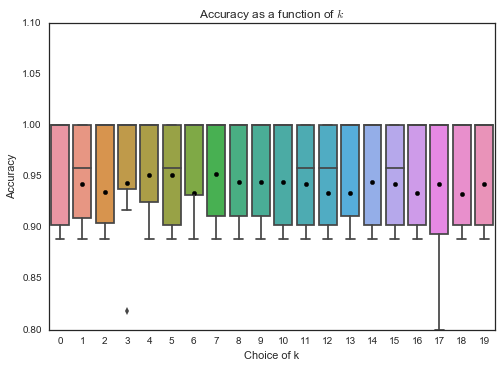

In [307]:
# your code here
sns.boxplot(data=scores)
plt.scatter(k, score_means, c='k', zorder=2)
plt.ylim(0.8, 1.1)
plt.title('Accuracy as a function of $k$')
plt.ylabel('Accuracy')
plt.xlabel('Choice of k')
plt.show()

Verify that the grid search has indeed chosen the right parameter value for kk.

In [308]:
# Your code here
clf.best_params_

{'n_neighbors': 4}

#### Problem 2(e)

Test the performance of our tuned KNN classifier on the test set.

In [280]:
# your code here
def computeTestScores(test_x, test_y, clf, cv):
    kFolds = sklearn.cross_validation.KFold(test_x.shape[0], n_folds=cv)
    
    scores = []
    for _, test_index in kFolds:
        test_data = test_x[test_index]
        test_labels = test_y[test_index]
        scores.append(sklearn.metrics.accuracy_score(test_labels, clf.predict(test_data)))
    return scores

In [281]:
# no measurement without standard deviation
scores = computeTestScores(test_x=X_test, test_y=Y_test, clf=clf, cv=5)
print(np.mean(scores), np.std(scores))

0.98 0.04


实际上，上面将测试集分为10分依次测试是多余的。

In [283]:
sklearn.metrics.accuracy_score(Y_test, clf.predict(X_test))

0.97999999999999998

## Discussion for Problem 2

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*
这里我们使用KNN和CV来找到预测水仙花物种的最优k值。我们发现最优的k值等于4（通过散点图看出）。水仙花数据集很好预测，所以测试的正确率接近1.

---

# Problem 3: The Curse and Blessing of Higher Dimensions

In this problem we will investigate the influence of higher dimensional spaces on the classification. The data set is again one of the standard data sets from sklearn. The [digits data set](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) is similar to the MNIST data set discussed in the lecture. The main difference is, that each digit is represented by an 8x8 pixel image patch, which is considerably smaller than the 28x28 pixels from MNIST. In addition, the gray values are restricted to 16 different values (4 bit), instead of 256 (8 bit) for MNIST. 

First we again load our data set.

In [309]:
digits = sklearn.datasets.load_digits()

X = digits.data  
Y = digits.target

print(X.shape, Y.shape)

(1797, 64) (1797,)


#### Problem 3(a) 

Start with the same steps as in Problem 2. Split the data into train and test set. Use 33% of the samples as test data. Print the dimensions of all the train and test data sets you created. 

In [310]:
# Your code here
X_train, X_test, Y_train, Y_test = sklearn.cross_validation.train_test_split(
    X, Y, test_size=0.33, random_state=42)

X_train_means = np.mean(X_train, axis=0)
X_train_centered = X_train - X_train_means
X_test_centered = X_test - X_train_means

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1203, 64)
(594, 64)
(1203,)
(594,)


#### Problem 3(b) 

Similar to Problem 2(b), create a scatter plot of the projections to the first two PCs.  Use the colors on the scatter plot to represent the different classes in the target data. How well can we separate the classes?

**Hint**: Use a `Colormap` in matplotlib to represent the diferent classes in the target data. 

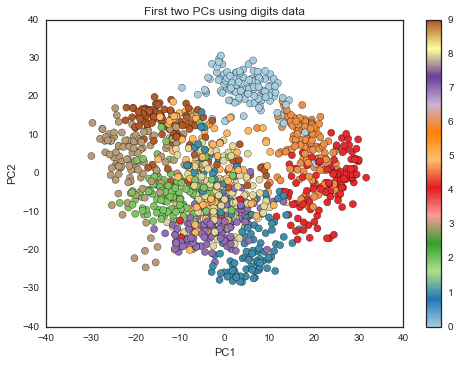

In [311]:
# Your code here
svd = sklearn.decomposition.TruncatedSVD(n_components=2)
X_2d = svd.fit_transform(X_train_centered)

plt.scatter(X_2d[:,0], X_2d[:,1], c=Y_train, s = 50, cmap=plt.cm.Paired)
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First two PCs using digits data')
plt.show()

Create individual scatter plots using only two classes at a time to explore which classes are most difficult to distinguish in terms of class separability. You do not need to create scatter plots for all pairwise comparisons, but at least show one.

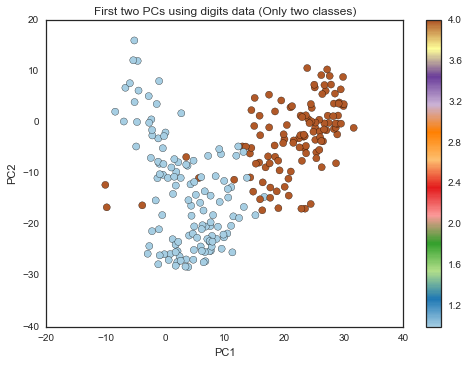

In [312]:
# Your code here
ind = np.logical_or(Y_train==4, Y_train==1)

plt.scatter(X_2d[ind,0], X_2d[ind,1], c=Y_train[ind], s = 50, cmap=plt.cm.Paired)
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First two PCs using digits data (Only two classes)')
plt.show()

Give a brief interpretation of the scatter plot. Which classes look like hard to distinguish? Do both feature dimensions contribute to the class separability?

回答：在上面显示的类4和1的散点图中，类分离得很好，但并不完全。决策边界与x轴几乎正交，这是一个指标，但是y轴上的第二维度对于类的可分离性没有太大贡献。

#### Problem 3(c) 

Write a **ten-fold cross validation** to estimate the optimal value for $k$ for the digits data set. *However*, this time we are interested in the influence of the number of dimensions we project the data down as well. 

Extend the cross validation as done for the iris data set, to optimize $k$ for different dimensional projections of the data. Create a boxplot showing test scores for the optimal $k$ for each $d$-dimensional subspace with $d$ ranging from one to ten. The plot should have the scores on the y-axis and the different dimensions $d$ on the x-axis. You can use your favorite plot function for the boxplots. [Seaborn](http://web.stanford.edu/~mwaskom/software/seaborn/index.html) is worth having a look at though. It is a great library for statistical visualization and of course also comes with a [`boxplot`](http://web.stanford.edu/~mwaskom/software/seaborn/generated/seaborn.boxplot.html) function that has simple means for changing the labels on the x-axis.

Possible solution A:
---------------------
Split the test data to get multiple test values. This is what I thought the sklearn.cross_val_score function would do for some reason. If somebody comes up with the clever idea to bootstrap the test set I would let that count as well. The main part just is to have multiple estimates of the test performance.

In [313]:
def computeTestScores(test_x, test_y, clf, cv):
    kFolds = sklearn.cross_validation.KFold(test_x.shape[0], n_folds=cv)

    scores = []
    for _, test_index in kFolds:
        test_data = test_x[test_index]
        test_labels = test_y[test_index]
        scores.append(sklearn.metrics.accuracy_score(test_labels, clf.predict(test_data)))
    return scores

In [289]:
# Your cross validation and evaluation code here

# use cross validation to find the optimal value for k
k = np.arange(20)+1
parameters = {'n_neighbors': k}
knn = sklearn.neighbors.KNeighborsClassifier()
clf = sklearn.grid_search.GridSearchCV(knn, parameters, cv=10)
all_scores = []
all_k = []
all_d = [1,2,3,4,5,6,7,8,9,10]

for d in all_d:
    print(d)
    svd = sklearn.decomposition.TruncatedSVD(n_components=d)
    if d<64:
        X_d = svd.fit_transform(X_train_centered)
        X_d_test = svd.fit_transform(X_test_centered)
    else:
        X_d = X_train
        X_d_test = X_test
    
    clf.fit(X_d, Y_train)
    
    all_scores.append(computeTestScores(test_x=X_d_test, test_y=Y_test, clf=clf, cv=10))
    all_k.append(clf.best_params_['n_neighbors'])

1
2
3
4
5
6
7
8
9
10


In [290]:
all_k

[12, 19, 12, 6, 6, 10, 3, 3, 3, 1]

方案一只是进行在不同d的情况下，固定训练集和测试集，对训练集进行交叉验证最好的k值，所以给出10个k值。

Really clean solution B:
-------------------------

Do nested k-fold cross validation, with the parameter estimated on an inner k-fold cross validation, and the test score estimated on the outer k-fold cross validation.

In [314]:
# use cross validation to find the optimal value for k
k = np.arange(20)+1
parameters = {'n_neighbors': k}
knn = sklearn.neighbors.KNeighborsClassifier()
clf = sklearn.grid_search.GridSearchCV(knn, parameters, cv=10)
all_scores = []
all_k = []
all_d = [1,2,3,4,5,6,7,8,9,10]
kFolds = sklearn.cross_validation.KFold(X.shape[0], n_folds=10)

for d in all_d:
    print(d)
    svd = sklearn.decomposition.TruncatedSVD(n_components=d)
    # get the data for this iteration of the outer cross validation loop
    scores = []
    for train_index, test_index in kFolds:
        train_data, test_data = X[train_index], X[test_index]
        train_labels, test_labels = Y[train_index], Y[test_index]
        
        if d < 64:
            data_mean = np.mean(train_data, axis=0)
            train_data_centered = train_data - data_mean
            test_data_centered = test_data - data_mean
            X_d = svd.fit_transform(train_data_centered)
            X_d_test = svd.transform(test_data_centered)
        else:
            X_d = train_data
            X_d_test = test_data
        
        clf.fit(X_d, train_labels)
        scores.append(sklearn.metrics.accuracy_score(test_labels, clf.predict(X_d_test)))
        
    all_scores.append(scores)
    all_k.append(clf.best_params_['n_neighbors'])

1
2
3
4
5
6
7
8
9
10


方案1中，在每个不同的d下，训练集都是一样的，只是训练集内部交叉验证选择最优的k值，然后放给固定的测试集得到分数。

方案2中，在每个不同的d下，都将数据分为10等分，每次训练和测试都是使用不同的数据块，然后再在训练集内部交叉验证选择最优的k值，然后给测试集得到分数，之后换一组训练和测试集。

D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


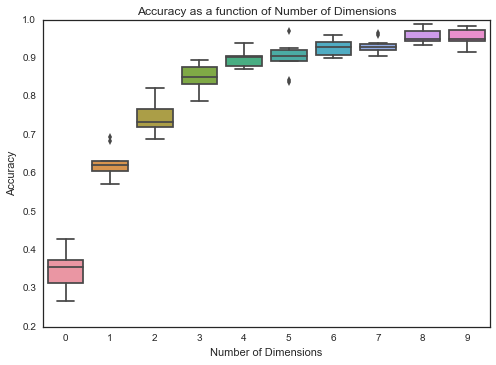

In [319]:
# Your boxplot code here 
all_s = np.asarray(all_scores) 
sns.boxplot(data=all_s.T,names = [np.str(dd) for dd in all_d])
plt.ylabel("Accuracy")
plt.xlabel("Number of Dimensions")
plt.title('Accuracy as a function of Number of Dimensions')
plt.show()

Write a short interpretation of the generated plot, answering the following questions:

* What trend do you see in the plot for increasing dimensions?

* Why do you think this is happening?

回答：随着维度的增加，精度越来越好。我们有足够的数据点，维度的诅咒不会损害我们在这里的预测，额外的维度增加了类的可分离性。有两个因素影响到这一点。一个是，如果我们减少数据的维数，我们会提取更多的原始信号信息。另一个因素是较高维数空间在数据点之间提供了更多的空间，因此为分类器提供了更多的灵活性。

#### Problem 3(d) 

Change the boxplot we generated above to also show the optimal value for $k$ chosen by the cross validation grid search. 

D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


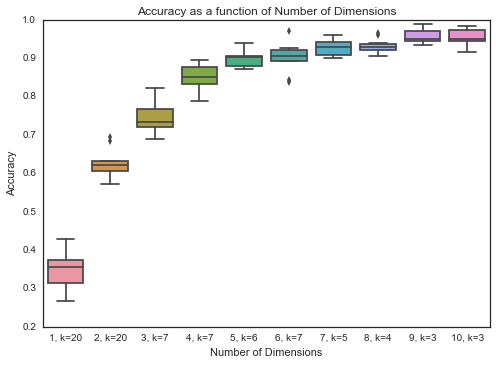

In [346]:
# Your code here 
all_s = np.asarray(all_scores) 
names = [np.str(dd) + ", k=" + np.str(kk) for dd, kk in zip(all_d, all_k)]
sns.boxplot(data=all_s.T, names=names)
plt.ylabel("Accuracy")
plt.xlabel("Number of Dimensions")
plt.xticks(range(10), names)
plt.title('Accuracy as a function of Number of Dimensions')
plt.show()

Write a short interpretation answering the following questions:

* Which trend do you observe for the optimal value of $k$?

* Why do you think this is happening?

回答：如果我们使用更高维的空间，k的优化值就会变小。我们已经在讲座中看到了一个新的数据点的KNN分类与k选择的值的变化。该图像还显示，如果k较大，则新数据点周围球体的半径变大，因为需要较大的搜索半径来找到更多数量的邻居点。在较高的维度空间中，数据点更加分散（维度诅咒）。因此，k值的提高使得搜索半径变大，使得k个最近邻居开始包括来自其他类的点。

## Discussion for Problem 3

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

如果我们使用高维度的空间，我们知道数据点会变得更加分散（维度诅咒），这导致k值的搜索半径变的相当大，以至于包含来自其他类的数据点。

---